In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [2]:

data_path = Path('../Data/Raw/Mendeley_data/100_Batches_IndPenSim_v3.csv')
df_raw = pd.read_csv(data_path)

variable_raman_data = np.split(df_raw, [df_raw.columns.get_loc("2400")], axis=1)
df = variable_raman_data[0].copy()

if '2-PAT control(PAT_ref:PAT ref)' in df.columns:
    df = df.rename(columns={
        '2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)',
        'Batch reference(Batch_ref:Batch ref)': '2-PAT control(PAT_ref:PAT ref)'
    })

batch_col = 'Batch reference(Batch_ref:Batch ref)'
fault_col = 'Fault reference(Fault_ref:Fault ref)'

critical_cols = ['Time (h)', 'Penicillin concentration(P:g/L)', batch_col, fault_col]
df = df.dropna(subset=critical_cols).reset_index(drop=True)

cols_to_drop = [batch_col, fault_col, 'Fault flag', 'Time (h)']
operator_cols = [col for col in df.columns if 'operator' in col.lower()]
cols_to_drop.extend(operator_cols)

all_feature_cols = [col for col in df.columns if col not in cols_to_drop]

print(f"Loaded: {len(df)} rows, {len(all_feature_cols)} features")

Loaded: 113935 rows, 34 features


In [3]:
# Top 5 Sensors from GBT the gbt experiment
top_5_sensors = [
    'Temperature(T:K)',
    'Acid flow rate(Fa:L/h)',
    'Dissolved oxygen concentration(DO2:mg/L)',
    'pH(pH:pH)',
    'Vessel Volume(V:L)'
]

sensors_found = [s for s in top_5_sensors if s in all_feature_cols]
print(f"Using {len(sensors_found)} sensors")

Using 5 sensors


In [4]:

def create_multi_step_sequences(sensor_data, batch_fault_info, seq_length=100, future_steps=50, normal_only=True):

    X, y = [], []
    batch_ids = []
    
    all_batches = sensor_data[batch_col].unique()
    faulty_batches = set(batch_fault_info.keys())
    normal_batches = set(all_batches) - faulty_batches
    
    print(f"Normal batches: {len(normal_batches)}, Faulty batches: {len(faulty_batches)}")
    
    batches_to_use = normal_batches if normal_only else all_batches
    
    for batch_id in batches_to_use:
        batch_data = sensor_data[sensor_data[batch_col] == batch_id].copy()
        
        if len(batch_data) < seq_length + future_steps:
            continue
        
        sensor_values = batch_data[sensors_found].values
        
        for i in range(len(sensor_values) - seq_length - future_steps + 1):
            X.append(sensor_values[i:i+seq_length])
            y.append(sensor_values[i+seq_length:i+seq_length+future_steps])
            batch_ids.append(batch_id)
    
    return np.array(X), np.array(y), np.array(batch_ids)

seq_length = 100  
future_steps = 50 

fault_info = {}
for batch_id in df[batch_col].unique():
    batch_data = df[df[batch_col] == batch_id]
    if batch_data[fault_col].max() > 0:  
        fault_type = batch_data[fault_col].max()
        fault_info[batch_id] = fault_type


X_normal, y_normal, batch_ids_seq = create_multi_step_sequences(
    df, fault_info, seq_length, future_steps, normal_only=True
)

print(f"Created {len(X_normal)} sequences from normal batches only")
print(f"Input shape: {X_normal.shape}")
print(f"Output shape: {y_normal.shape}")

Normal batches: 90, Faulty batches: 10
Created 89000 sequences from normal batches only
Input shape: (89000, 100, 5)
Output shape: (89000, 50, 5)


In [5]:

scaler_X = StandardScaler()
scaler_y = StandardScaler()


n_samples, n_timesteps, n_features = X_normal.shape
X_flat = X_normal.reshape(-1, n_features)
X_scaled_flat = scaler_X.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(n_samples, n_timesteps, n_features)


y_flat = y_normal.reshape(-1, n_features)
y_scaled_flat = scaler_y.fit_transform(y_flat)
y_scaled = y_scaled_flat.reshape(n_samples, future_steps, n_features)

print(f"X: mean={X_scaled.mean():.4f}, std={X_scaled.std():.4f}")
print(f"y: mean={y_scaled.mean():.4f}, std={y_scaled.std():.4f}")

X: mean=-0.0000, std=1.0000
y: mean=-0.0000, std=1.0000


In [6]:

unique_normal_batches = np.unique(batch_ids_seq)

train_size = int(0.7 * len(unique_normal_batches))
val_size = int(0.2 * len(unique_normal_batches))

train_batches = unique_normal_batches[:train_size]
val_batches = unique_normal_batches[train_size:train_size + val_size]
test_batches = unique_normal_batches[train_size + val_size:]

train_mask = np.isin(batch_ids_seq, train_batches)
val_mask = np.isin(batch_ids_seq, val_batches)
test_mask = np.isin(batch_ids_seq, test_batches)

X_train, y_train = X_scaled[train_mask], y_scaled[train_mask]
X_val, y_val = X_scaled[val_mask], y_scaled[val_mask]
X_test, y_test = X_scaled[test_mask], y_scaled[test_mask]

print(f"Train: {len(X_train)} sequences from {len(train_batches)} batches")
print(f"Val: {len(X_val)} sequences from {len(val_batches)} batches")
print(f"Test: {len(X_test)} sequences from {len(test_batches)} batches")

Train: 61827 sequences from 62 batches
Val: 17343 sequences from 18 batches
Test: 9830 sequences from 10 batches


In [7]:

model = Sequential([
    LSTM(32, activation='tanh', return_sequences=True, 
         input_shape=(seq_length, len(sensors_found))),
    Dropout(0.2),
    
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    
    Dense(future_steps * len(sensors_found))
], name='Sensor_Prediction_LSTM')


def reshape_output(x):
    return tf.reshape(x, (-1, future_steps, len(sensors_found)))

model.add(layers.Lambda(reshape_output))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.Huber(delta=1.0),
    metrics=['mae']
)

model.summary()

Model: "Sensor_Prediction_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 32)        │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 50, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,434 (83.73 KB)

 Trainable params: 21,434 (83.73 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - loss: 0.2625 - mae: 0.5185 - val_loss: 0.2174 - val_mae: 0.4525 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 521ms/step - loss: 0.1984 - mae: 0.4318 - val_loss: 0.1613 - val_mae: 0.3692 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - loss: 0.1592 - mae: 0.3669 - val_loss: 0.1390 - val_mae: 0.3263 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 551ms/step - loss: 0.1448 - mae: 0.3376 - val_loss: 0.1322 - val_mae: 0.3106 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - loss: 0.1402 - mae: 0.3269 - val_loss: 0.1290 - val_mae: 0.3039 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 547ms/step - loss: 0.1376 - mae: 0.3209 - val_loss: 0.1273 - val_mae: 0.2997 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 511ms/step - loss: 0.1355 - mae: 0.3165 - val_loss: 0.1257 - val_mae: 0.2961 - learning_rate: 0.0010

In [9]:

print(f"\nTraining completed: {len(history.history['loss'])} epochs")
print(f"Available metrics: {list(history.history.keys())}")


Training completed: 50 epochs
Available metrics: ['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate']


In [10]:

y_pred_scaled = model.predict(X_test, verbose=0)


y_pred_flat = y_pred_scaled.reshape(-1, len(sensors_found))
y_pred = scaler_y.inverse_transform(y_pred_flat).reshape(-1, future_steps, len(sensors_found))

y_test_flat = y_test.reshape(-1, len(sensors_found))
y_test_actual = scaler_y.inverse_transform(y_test_flat).reshape(-1, future_steps, len(sensors_found))

mae = np.mean(np.abs(y_pred - y_test_actual))
rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))

print(f"\nTest Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Test Performance:
MAE: 162.5084
RMSE: 539.8222


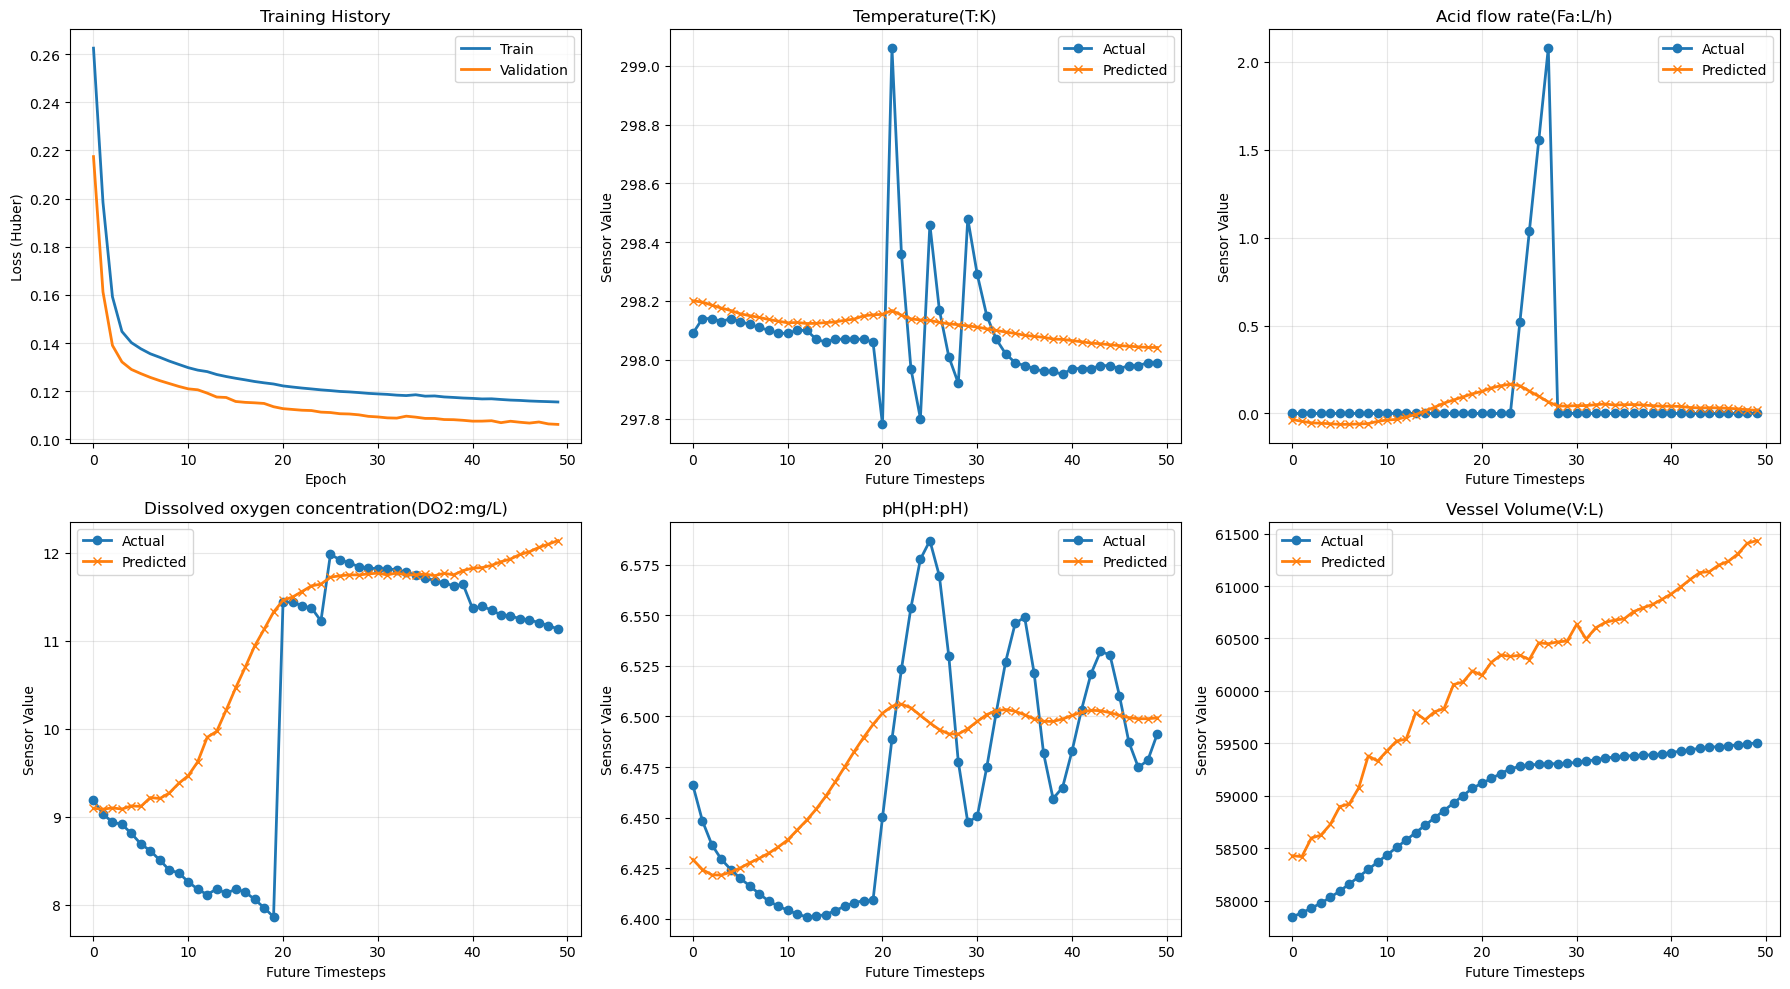

In [11]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))


ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Huber)')
ax.set_title('Training History')
ax.legend()
ax.grid(alpha=0.3)


sample_idx = 0
for i, sensor_name in enumerate(sensors_found):
    row = (i + 1) // 3
    col = (i + 1) % 3
    ax = axes[row, col]
    
    ax.plot(range(future_steps), y_test_actual[sample_idx, :, i], 
            marker='o', label='Actual', linewidth=2)
    ax.plot(range(future_steps), y_pred[sample_idx, :, i], 
            marker='x', label='Predicted', linewidth=2)
    ax.set_xlabel('Future Timesteps')
    ax.set_ylabel('Sensor Value')
    ax.set_title(sensor_name)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

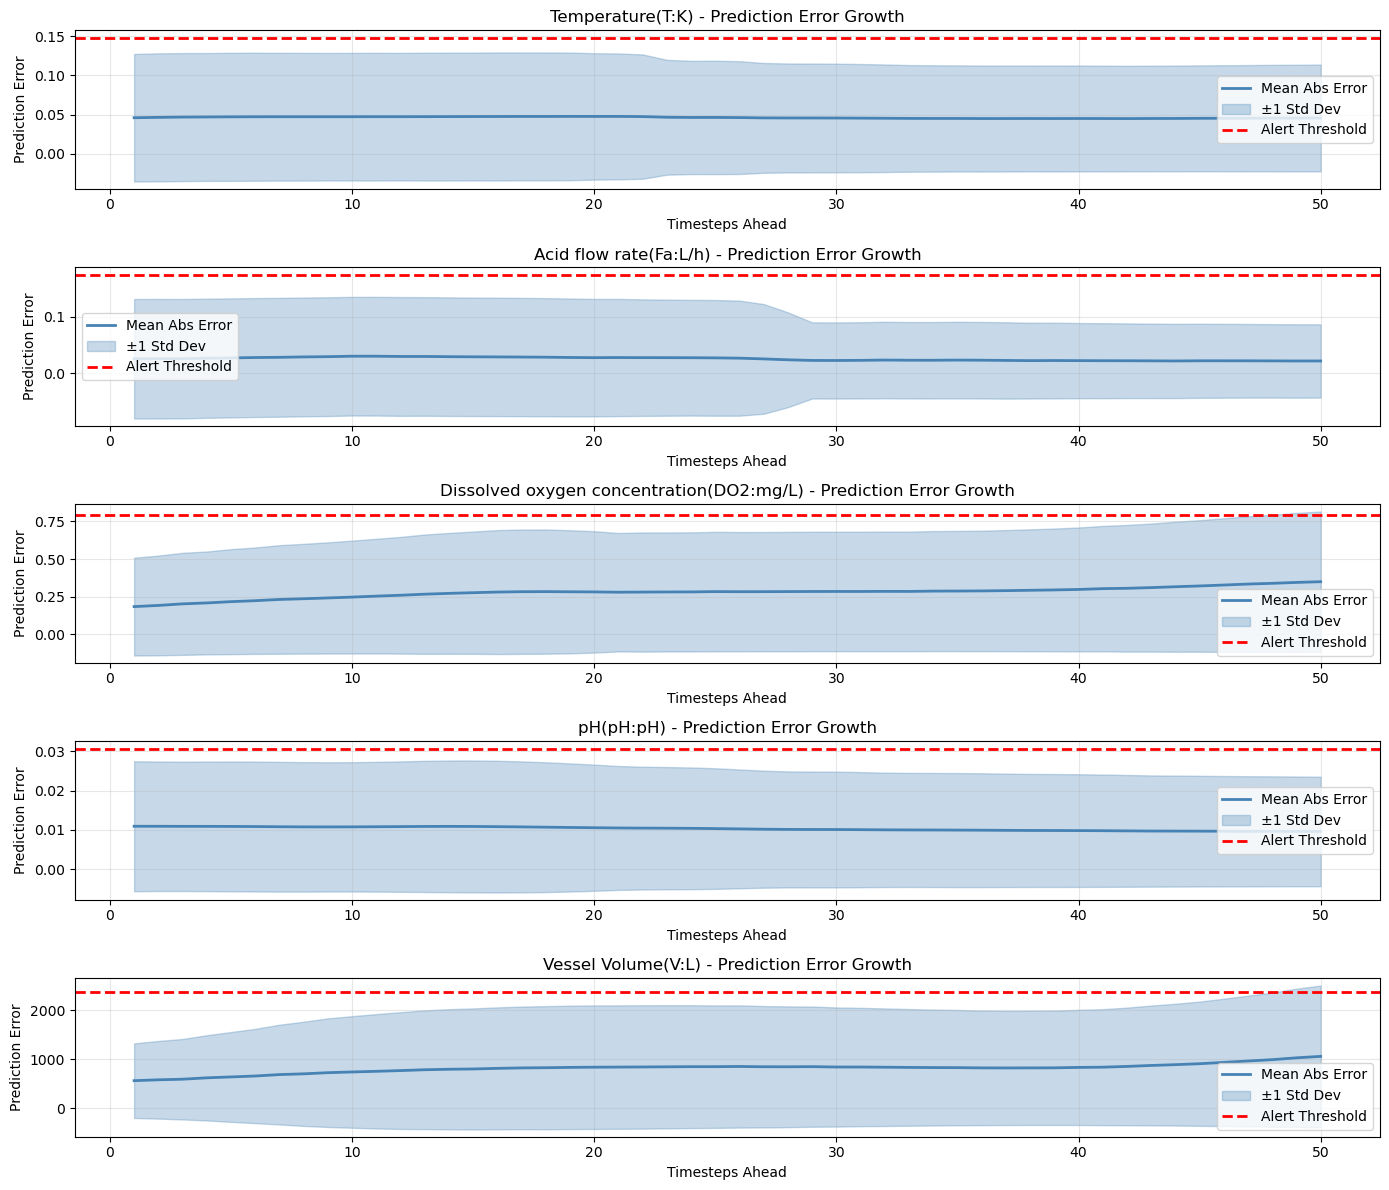

In [12]:

deviation_threshold = 2.0 

fig, axes = plt.subplots(len(sensors_found), 1, figsize=(14, 12))

for i, sensor_name in enumerate(sensors_found):
    ax = axes[i]
    
   
    errors = y_pred[:, :, i] - y_test_actual[:, :, i]
    

    mean_abs_dev = np.mean(np.abs(errors), axis=0)
    std_dev = np.std(errors, axis=0)
    
    timesteps = range(1, future_steps + 1)
    
    ax.plot(timesteps, mean_abs_dev, linewidth=2, color='steelblue', label='Mean Abs Error')
    ax.fill_between(timesteps, 
                     mean_abs_dev - std_dev, 
                     mean_abs_dev + std_dev, 
                     alpha=0.3, color='steelblue', label='±1 Std Dev')
    ax.axhline(deviation_threshold * np.mean(std_dev), 
               color='red', linestyle='--', linewidth=2, label='Alert Threshold')
    
    ax.set_xlabel('Timesteps Ahead')
    ax.set_ylabel('Prediction Error')
    ax.set_title(f'{sensor_name} - Prediction Error Growth')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Below you can find the approach for the early warning system evaluation 

In [13]:

for sensor_idx, sensor_name in enumerate(sensors_found):
    errors = np.abs(y_pred[:, :, sensor_idx] - y_test_actual[:, :, sensor_idx])
    
    threshold = deviation_threshold * np.std(errors)
    
    early_warnings = []
    for sample_errors in errors:
        exceeds = np.where(sample_errors > threshold)[0]
        if len(exceeds) > 0:
            early_warnings.append(exceeds[0] + 1) 
    
    if len(early_warnings) > 0:
        avg_warning_time = np.mean(early_warnings)
        print(f"\n{sensor_name}:")
        print(f"  Average early warning: {avg_warning_time:.1f} timesteps ahead")
        print(f"  Detection rate: {len(early_warnings)/len(errors)*100:.1f}%")
    else:
        print(f"\n{sensor_name}: No anomalies detected above threshold")



Temperature(T:K):
  Average early warning: 15.0 timesteps ahead
  Detection rate: 58.9%

Acid flow rate(Fa:L/h):
  Average early warning: 20.2 timesteps ahead
  Detection rate: 15.8%

Dissolved oxygen concentration(DO2:mg/L):
  Average early warning: 20.1 timesteps ahead
  Detection rate: 45.8%

pH(pH:pH):
  Average early warning: 16.6 timesteps ahead
  Detection rate: 57.0%

Vessel Volume(V:L):
  Average early warning: 19.6 timesteps ahead
  Detection rate: 37.1%


In [14]:

X_faulty, y_faulty, batch_ids_faulty = create_multi_step_sequences(
    df, fault_info, seq_length, future_steps, normal_only=False
)


faulty_batch_set = set(fault_info.keys())
faulty_mask = np.isin(batch_ids_faulty, list(faulty_batch_set))

X_faulty_test = X_faulty[faulty_mask]
y_faulty_test = y_faulty[faulty_mask]
batch_ids_faulty_test = batch_ids_faulty[faulty_mask]

print(f"Faulty sequences: {len(X_faulty_test)} from {len(np.unique(batch_ids_faulty_test))} batches")


X_faulty_flat = X_faulty_test.reshape(-1, len(sensors_found))
X_faulty_scaled_flat = scaler_X.transform(X_faulty_flat)  
X_faulty_scaled = X_faulty_scaled_flat.reshape(len(X_faulty_test), seq_length, len(sensors_found))

y_faulty_flat = y_faulty_test.reshape(-1, len(sensors_found))
y_faulty_scaled_flat = scaler_y.transform(y_faulty_flat)
y_faulty_scaled = y_faulty_scaled_flat.reshape(len(X_faulty_test), future_steps, len(sensors_found))

Normal batches: 90, Faulty batches: 10
Faulty sequences: 10035 from 10 batches


In [15]:



y_pred_faulty_scaled = model.predict(X_faulty_scaled, verbose=0)


y_pred_faulty_flat = y_pred_faulty_scaled.reshape(-1, len(sensors_found))
y_pred_faulty = scaler_y.inverse_transform(y_pred_faulty_flat).reshape(-1, future_steps, len(sensors_found))

y_faulty_actual_flat = y_faulty_scaled.reshape(-1, len(sensors_found))
y_faulty_actual = scaler_y.inverse_transform(y_faulty_actual_flat).reshape(-1, future_steps, len(sensors_found))


anomaly_scores = np.abs(y_pred_faulty - y_faulty_actual)

print("\nAnomaly Scores by Sensor:")
for i, sensor_name in enumerate(sensors_found):
    sensor_anomalies = anomaly_scores[:, :, i]
    mean_anomaly = np.mean(sensor_anomalies)
    max_anomaly = np.max(sensor_anomalies)
    
    print(f"\n{sensor_name}:")
    print(f"  Mean deviation from normal: {mean_anomaly:.4f}")
    print(f"  Max deviation from normal: {max_anomaly:.4f}")
    print(f"  Avg deviation at timestep 1: {np.mean(sensor_anomalies[:, 0]):.4f}")
    print(f"  Avg deviation at timestep {future_steps}: {np.mean(sensor_anomalies[:, -1]):.4f}")


Anomaly Scores by Sensor:

Temperature(T:K):
  Mean deviation from normal: 0.1565
  Max deviation from normal: 4.1316
  Avg deviation at timestep 1: 0.1517
  Avg deviation at timestep 50: 0.1575

Acid flow rate(Fa:L/h):
  Mean deviation from normal: 0.2374
  Max deviation from normal: 13.0313
  Avg deviation at timestep 1: 0.2347
  Avg deviation at timestep 50: 0.2370

Dissolved oxygen concentration(DO2:mg/L):
  Mean deviation from normal: 0.4305
  Max deviation from normal: 12.9937
  Avg deviation at timestep 1: 0.3338
  Avg deviation at timestep 50: 0.5138

pH(pH:pH):
  Mean deviation from normal: 0.0332
  Max deviation from normal: 0.9051
  Avg deviation at timestep 1: 0.0290
  Avg deviation at timestep 50: 0.0354

Vessel Volume(V:L):
  Mean deviation from normal: 1392.9540
  Max deviation from normal: 11613.9062
  Avg deviation at timestep 1: 889.8922
  Avg deviation at timestep 50: 1897.9184


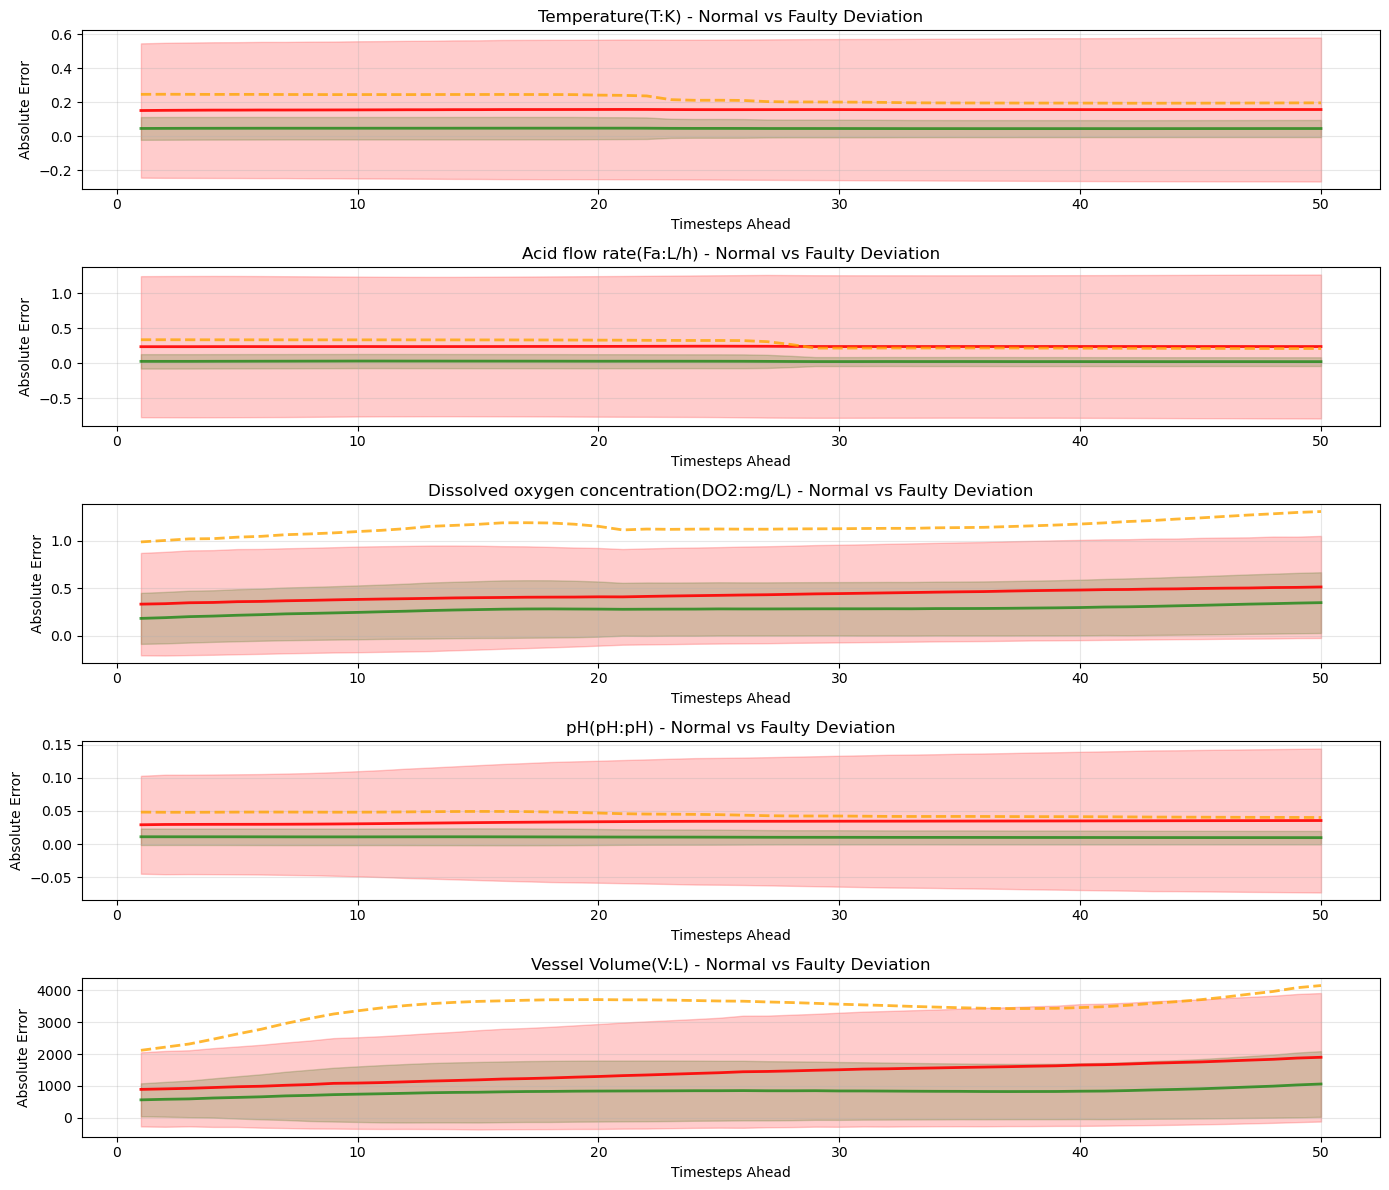

In [16]:

fig, axes = plt.subplots(len(sensors_found), 1, figsize=(14, 12))


normal_errors = np.abs(y_pred - y_test_actual)

for i, sensor_name in enumerate(sensors_found):
    ax = axes[i]
    

    normal_mae = np.mean(normal_errors[:, :, i], axis=0)
    normal_std = np.std(normal_errors[:, :, i], axis=0)
    
   
    faulty_mae = np.mean(anomaly_scores[:, :, i], axis=0)
    faulty_std = np.std(anomaly_scores[:, :, i], axis=0)
    
    timesteps = range(1, future_steps + 1)
    
    
    ax.plot(timesteps, normal_mae, linewidth=2, color='green', 
            label='Normal Batches (Prediction Error)', alpha=0.7)
    ax.fill_between(timesteps, 
                     normal_mae - normal_std, 
                     normal_mae + normal_std, 
                     alpha=0.2, color='green')
    
    
    ax.plot(timesteps, faulty_mae, linewidth=2, color='red', 
            label='Faulty Batches (Anomaly Score)', alpha=0.9)
    ax.fill_between(timesteps, 
                     faulty_mae - faulty_std, 
                     faulty_mae + faulty_std, 
                     alpha=0.2, color='red')
    
    
    threshold = normal_mae + 3 * normal_std
    ax.plot(timesteps, threshold, linewidth=2, linestyle='--', 
            color='orange', label='Anomaly Threshold (3σ)', alpha=0.8)
    
    ax.set_xlabel('Timesteps Ahead')
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'{sensor_name} - Normal vs Faulty Deviation')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print("Process Diagnostics")

for i, sensor_name in enumerate(sensors_found):
    normal_mae = np.mean(normal_errors[:, :, i], axis=0)
    normal_std = np.std(normal_errors[:, :, i], axis=0)
    threshold = normal_mae + 3 * normal_std
    
    detection_times = []
    for seq_idx in range(len(anomaly_scores)):
        seq_anomalies = anomaly_scores[seq_idx, :, i]
        exceeds = np.where(seq_anomalies > threshold)[0]
        if len(exceeds) > 0:
            detection_times.append(exceeds[0] + 1)
    
    if len(detection_times) > 0:
        avg_detection = np.mean(detection_times)
        detection_rate = len(detection_times) / len(anomaly_scores) * 100
        
        print(f"\n{sensor_name}:")
        print(f"  Detectable at: {avg_detection:.1f} timesteps ahead")
        print(f"  Detection reliability: {detection_rate:.1f}%")
        print(f"  Avg deviation: {np.mean(anomaly_scores[:, :, i]):.3f}")
        
        if avg_detection < future_steps / 3:
            print(f"  Priority: CRITICAL - Early warning sensor")
        elif detection_rate > 80:
            print(f"  Priority: HIGH - Reliable indicator")
        else:
            print(f"  Priority: SECONDARY - Less consistent")
    else:
        print(f"\n{sensor_name}: Weak indicator")

Process Diagnostics

Temperature(T:K):
  Detectable at: 15.6 timesteps ahead
  Detection reliability: 57.1%
  Avg deviation: 0.157
  Priority: CRITICAL - Early warning sensor

Acid flow rate(Fa:L/h):
  Detectable at: 20.8 timesteps ahead
  Detection reliability: 38.4%
  Avg deviation: 0.237
  Priority: SECONDARY - Less consistent

Dissolved oxygen concentration(DO2:mg/L):
  Detectable at: 16.4 timesteps ahead
  Detection reliability: 25.5%
  Avg deviation: 0.430
  Priority: CRITICAL - Early warning sensor

pH(pH:pH):
  Detectable at: 18.7 timesteps ahead
  Detection reliability: 46.8%
  Avg deviation: 0.033
  Priority: SECONDARY - Less consistent

Vessel Volume(V:L):
  Detectable at: 17.7 timesteps ahead
  Detection reliability: 29.6%
  Avg deviation: 1392.954
  Priority: SECONDARY - Less consistent


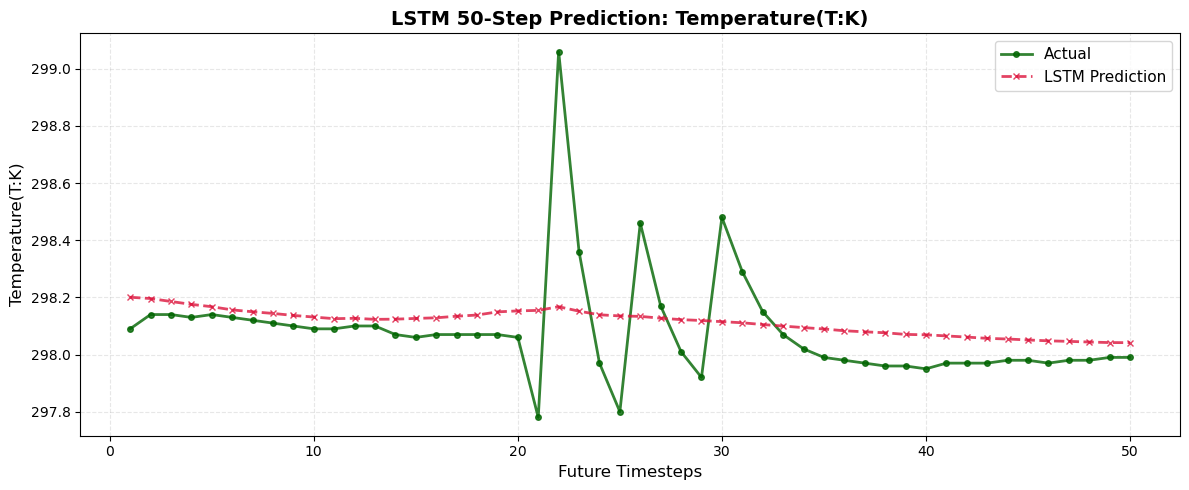

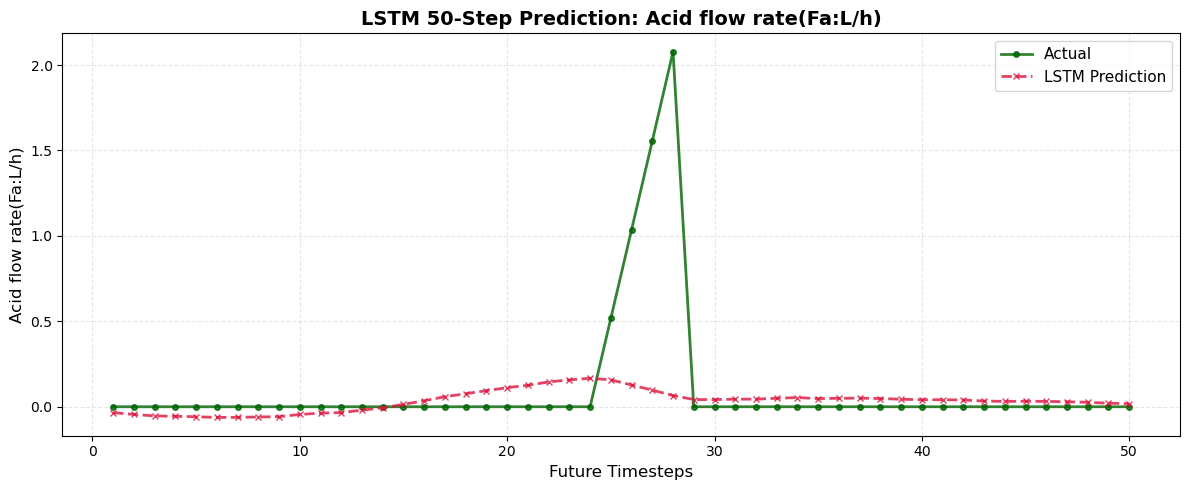

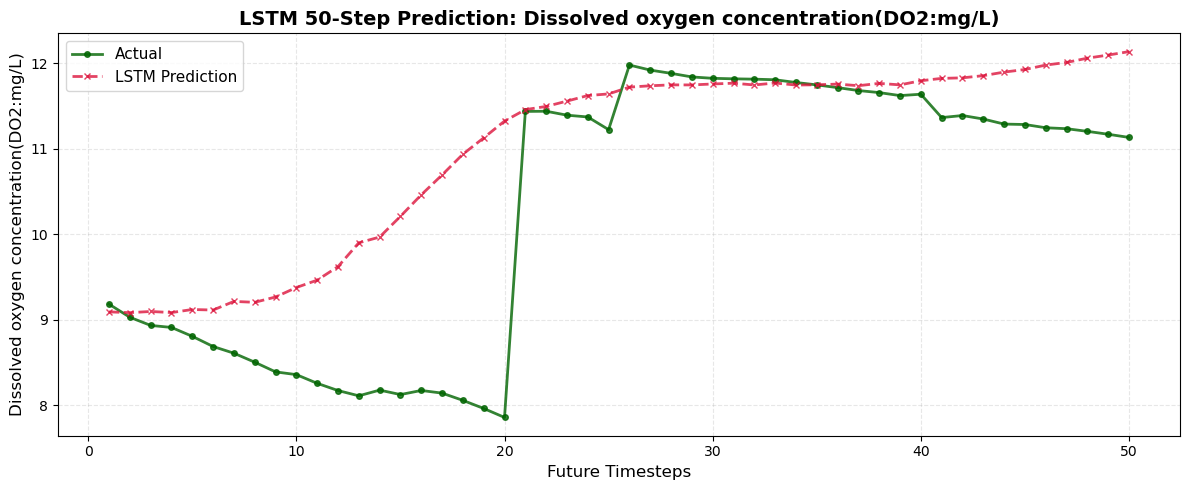

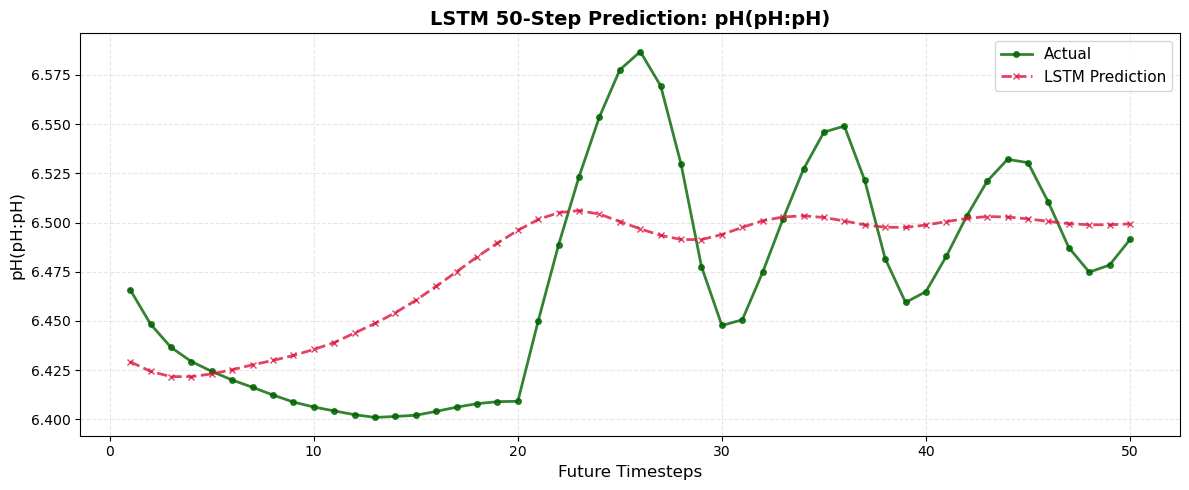

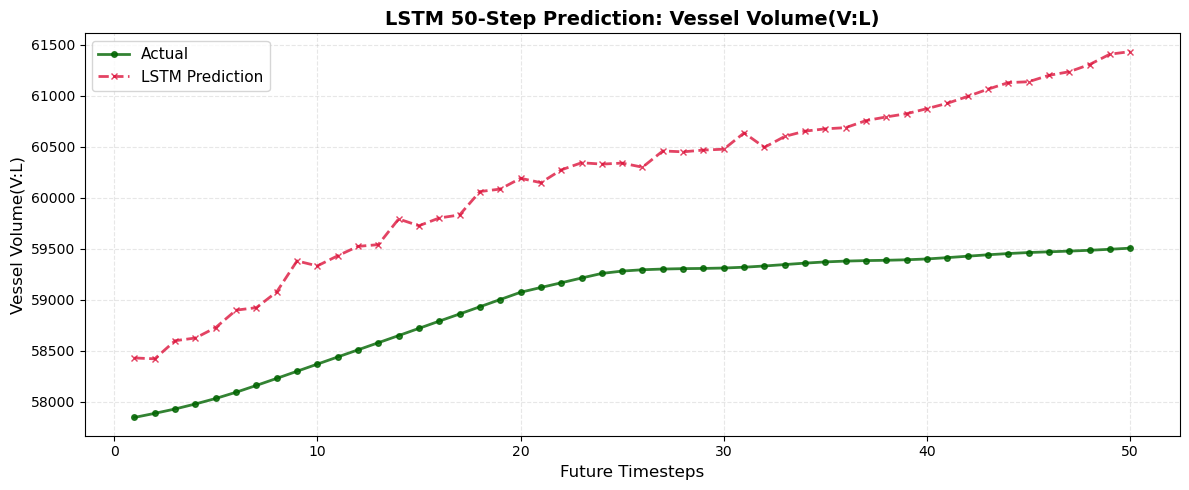

In [18]:

sample_idx = 0  

for i, sensor_name in enumerate(sensors_found):
    plt.figure(figsize=(12, 5))
    
    timesteps = range(1, future_steps + 1)
    
    plt.plot(timesteps, y_test_actual[sample_idx, :, i], 
             marker='o', markersize=4, label='Actual', linewidth=2, 
             color='darkgreen', alpha=0.8)
    plt.plot(timesteps, y_pred[sample_idx, :, i], 
             marker='x', markersize=4, label='LSTM Prediction', linewidth=2, 
             color='crimson', alpha=0.8, linestyle='--')
    
    plt.xlabel('Future Timesteps', fontsize=12)
    plt.ylabel(f'{sensor_name}', fontsize=12)
    plt.title(f'LSTM 50-Step Prediction: {sensor_name}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    plt.show()
